In [1]:
%%capture

import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
rng = d3p.random.PRNGKey(42526709)
data_gen_rng, inference_rng = d3p.random.split(rng)
data_gen_rng = d3p.random.convert_to_jax_rng_key(data_gen_rng)

#### Prepare dataset

Generate 10 000 rows of datapoints for logistic regression task with true coefficients (1, 3, -4, 2, 1)

In [4]:
coefficients = [1.0, 3.0, -4.0, 2.0, 1.0]
dataset = BinaryLogisticRegressionDataGenerator(jnp.array(coefficients)).generate_data(n=10000, rng_key=data_gen_rng)

In [5]:
orig_df = pd.DataFrame(dataset, dtype="int")
n, d = orig_df.shape

In [6]:
orig_df

,0,1,2,3,4,5
0,1,0,1,1,1,1
1,1,0,1,0,0,0
2,1,1,0,0,1,1
3,1,1,1,0,0,0
4,1,0,0,1,0,1
...,...,...,...,...,...,...
9995,1,0,0,1,0,1
9996,1,1,1,0,1,0
9997,1,1,0,0,0,1
9998,1,1,0,0,1,1


#### Run logistic regression on original data

We define logistic regression model with original data and after fit we see coefficients approximately match the true coefficients 

In [66]:
X_array_orig = orig_df.to_numpy()[:,:-1]
y_array_orig = orig_df.to_numpy()[:,-1]

logistic_regression_result_with_orig = sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()

In [67]:
logistic_regression_result_with_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3309.6
Date:                Thu, 01 Dec 2022   Deviance:                       6619.2
Time:                        15:19:52   Pearson chi2:                 8.70e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4585
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0905      0.059     18.372      0.000       0.974       1.207
x2             3.0326      0.074     40.914      0.000       2.887       3.178
x3            -4.0318      0.087    -46.566      0.000      -4.202      -3.862
x4             1.9818      0.067     29.568      0.000       1.850       2.113
x5             0.9878      0.058     16.905      0.000       0.873       1.102
==============================================================================
"""

#### Create NapsuMQModel and fit the probabilistic model with DP

In [131]:
# Fitting the model takes few minutes

rng = d3p.random.PRNGKey(74249069)
inference_rng, sampling_rng = d3p.random.split(rng)

# We can define column marginal relationships that we want to preserve
column_feature_set = [(0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (0, 1), (1, 2), (2, 3), (3, 4), (0, 2), (1, 3), (2, 4)]

model = NapsuMQModel(column_feature_set=column_feature_set)
result = model.fit(
    data=orig_df,
    rng=inference_rng,
    epsilon=1,
    delta=(n ** (-2)),
    use_laplace_approximation=False
)

/home/local/jarlehti/projects/twinify/twinify/mst.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon = np.sqrt(8 * rho / (r - 1))
  0%|                                                                                                                | 0/19 [00:00<?, ?it/s]
2it [00:00, 13336.42it/s]

4it [00:00, 16594.67it/s]

2it [00:00, 16480.57it/s]

4it [00:00, 9182.93it/s]

4it [00:00, 25653.24it/s]

4it [00:00, 27324.46it/s]

4it [00:00, 22610.80it/s]

2it [00:00, 22733.36it/s]

2it [00:00, 22795.13it/s]

4it [00:00, 18456.78it/s]

4it [00:00, 23205.00it/s]

4it [00:00, 8289.14it/s]

4it [00:00, 25930.78it/s]

4it [00:00, 11658.94it/s]

2it [00:00, 7307.15it/s]

2it [00:00, 7469.82it/s]

4it [00:00, 10922.67it/s]

4it [00:00, 11626.62it/s]
sample: 100%|████████████████████████████████████████████████| 2800/2800 [00:03<00:00, 793.33it/s, 7 steps of size 5.26e-01. acc. prob=0.90]


#### Create a synthetic dataset using probabilistic model

In [132]:
synthetic_dfs = result.generate(
    rng=sampling_rng, 
    num_data_per_parameter_sample=10000, 
    num_parameter_samples=50,
    single_dataframe=False
)

#### Run logistic regression on synthetic data

In [133]:
q = np.zeros((len(synthetic_dfs), len(coefficients)))
u = np.zeros((len(synthetic_dfs), len(coefficients)))

for i, syn_df in enumerate(synthetic_dfs):
    X_array_syn = syn_df.to_numpy()[:,:-1]
    y_array_syn = syn_df.to_numpy()[:,-1]
        
    logistic_regression_result_with_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
    
    q[i, :] = logistic_regression_result_with_syn.params
    u[i, :] = logistic_regression_result_with_syn.bse**2

#### Calculate confidence intervals from point estimates and variance estimates using Rubin's rules

In [134]:
synthetic_data_confidence_intervals = []

for i in range(len(coefficients)):
    ci = rubins_rules.conf_int(q[:,i], u[:,i], 0.95)
    synthetic_data_confidence_intervals.append(ci)

#### Plot and compare the results

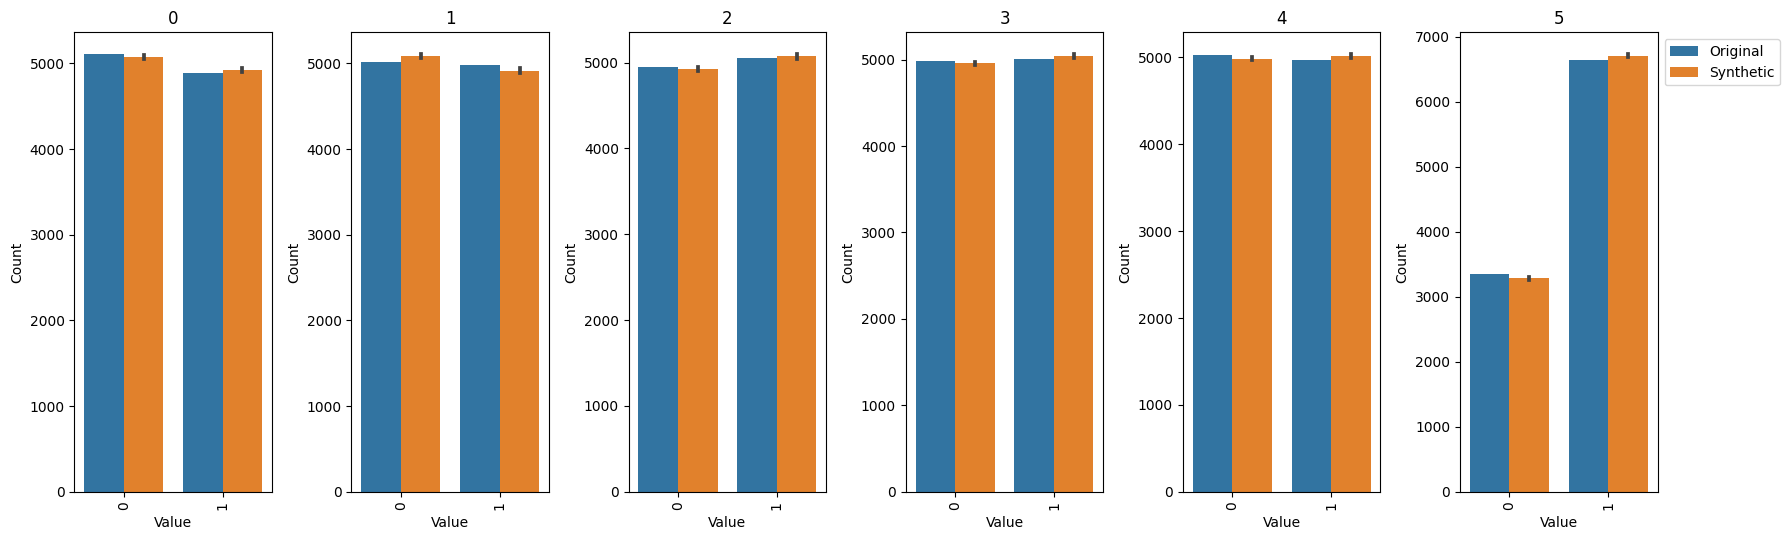

In [135]:
def value_count_list(df, col, type):
    counts = df[col].value_counts()
    return [(value, counts[value], type) for value in counts.index]

def value_count_df(orig_df, synthetic_dfs, col):
    vl_list = value_count_list(orig_df, col, "Original")
    for synthetic_df in synthetic_dfs:
        vl_list += (value_count_list(synthetic_df, col, "Synthetic"))

    return pd.DataFrame.from_records(vl_list, columns=["Value", "Count", "Type"])

value_count_dfs = { col: value_count_df(orig_df, synthetic_dfs, col) for col in orig_df.columns }

fig, axes = plt.subplots(1, len(value_count_dfs.items()), figsize=(3 * len(value_count_dfs.items()), 5.5))
for i, (key, value) in enumerate(value_count_dfs.items()):
    ax = axes[i]
    ax.set_title(key)
    ax.tick_params("x", labelrotation=90)
    sns.barplot(x="Value", y="Count", data=value_count_dfs[key], hue="Type", estimator=np.mean, ax=ax)
    if i < len(value_count_dfs.items()) - 1: 
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1.00, 1))
        
plt.tight_layout()
plt.show()

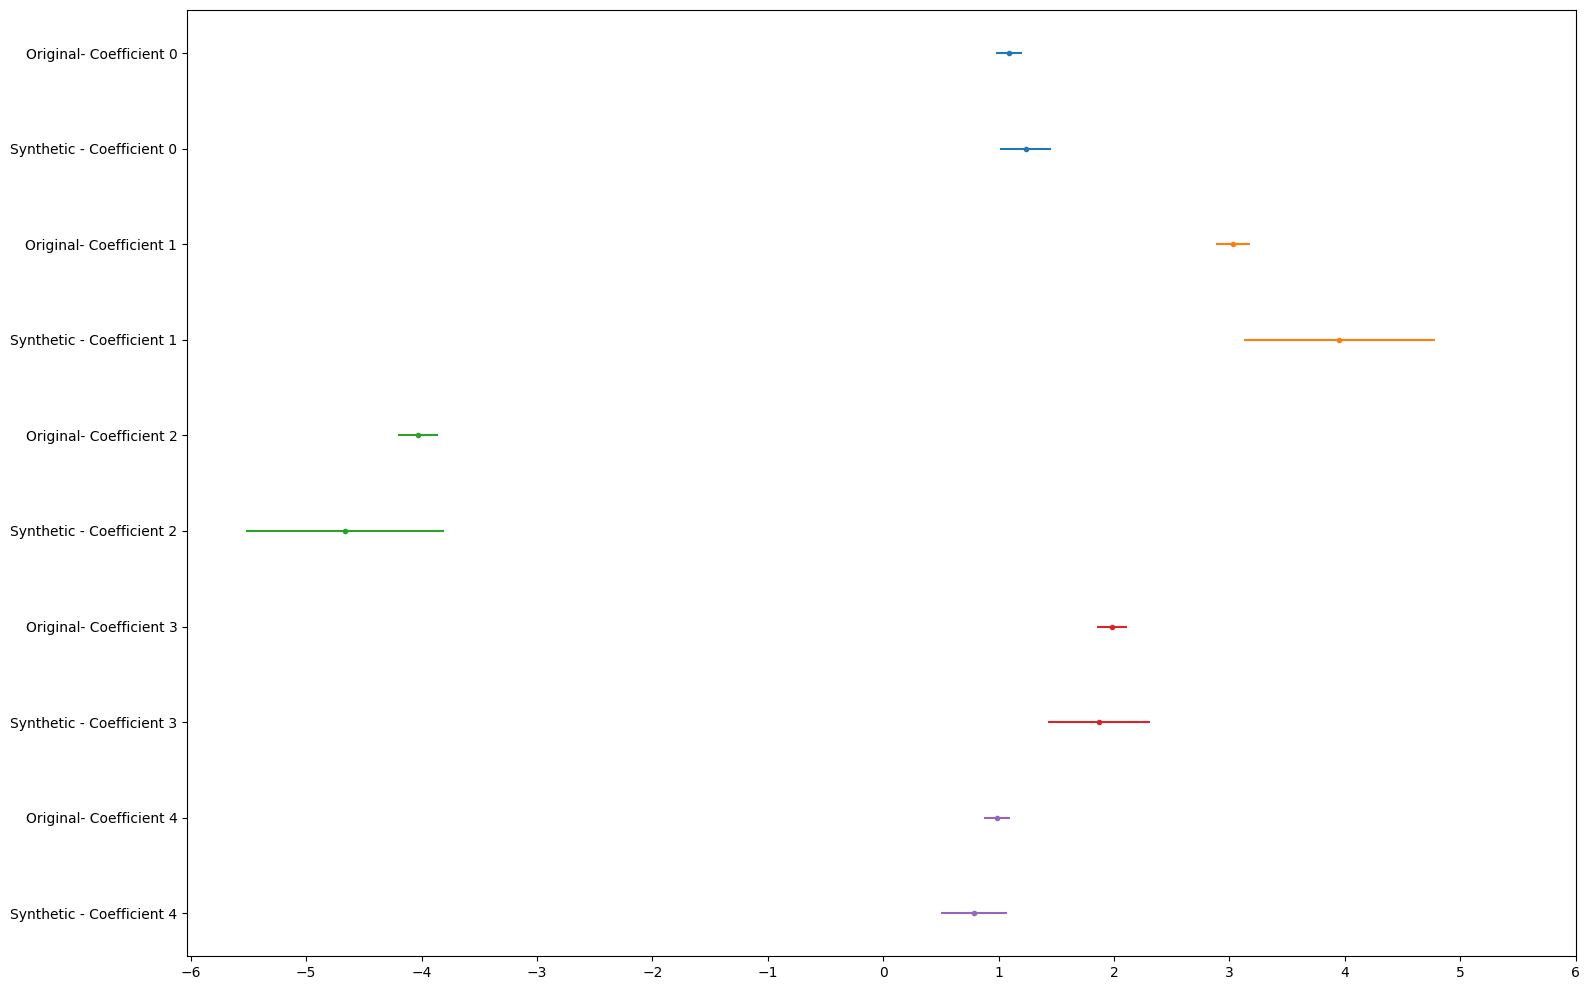

In [137]:
original_data_confidence_intervals = logistic_regression_result_with_orig.conf_int()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.subplots(figsize=(16, 10))
for i in reversed(range(len(coefficients))):
    original_lr_coefficient_mean = np.mean(original_data_confidence_intervals[i])
    synthetic_lr_coefficient_mean = np.mean(synthetic_data_confidence_intervals[i])
    original_lr_coefficient_radius = (original_data_confidence_intervals[i][1] - original_data_confidence_intervals[i][0]) * 0.5
    synthetic_lr_coefficient_radius = (synthetic_data_confidence_intervals[i][1] - synthetic_data_confidence_intervals[i][0]) * 0.5
    plt.errorbar(synthetic_lr_coefficient_mean, y=[f"Synthetic - Coefficient {i}"], xerr=synthetic_lr_coefficient_radius, fmt=".", color=colors[i])
    plt.errorbar(original_lr_coefficient_mean, y=[f"Original- Coefficient {i}"], xerr=original_lr_coefficient_radius, fmt=".", color=colors[i])

plt.xticks(range(-6, 7))
plt.tight_layout()
plt.show()